In [12]:
%load_ext rpy2.ipython

from cap2.capalyzer.pangea import PangeaFileSource
from cap2.capalyzer.pangea.utils import get_pangea_group
from cap2.capalyzer.table_builder import CAPTableBuilder

from plotnine import *
import pandas as pd
import warnings
from glob import glob
from os.path import isfile
from os import environ

warnings.filterwarnings('ignore')

twins_group = get_pangea_group('Mason Lab', 'NASA Twins', 'dcdanko@gmail.com', environ.get('PANGEA_PASS'))
twins_source = PangeaFileSource(twins_group)
twins = CAPTableBuilder('twins', twins_source)
iss_group = get_pangea_group('Mason Lab', 'NASA ISS', 'dcdanko@gmail.com', environ.get('PANGEA_PASS'))
iss_source = PangeaFileSource(iss_group)
iss = CAPTableBuilder('iss', iss_source)

twins_filepaths = list(twins_source('cap2::experimental::make_snp_clusters', 'snp_clusters__Neisseria_elongata'))
iss_filepaths = list(iss_source('cap2::experimental::make_snp_clusters', 'snp_clusters__Neisseria_elongata'))

print(len(twins_filepaths), len(iss_filepaths))


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
50 58


In [13]:

import networkx as nx


class SNPBarcode:

    def __init__(self, tbl):
        self.tbl = tbl
        self.sample_name = tbl['sample_name'].unique()[0]
        self.seq = tbl['seq'].unique()[0]
        self.snps = set(zip(tbl['coord'], tbl['changed']))

    def __len__(self):
        return len(self.snps)


class SNPBarcodeSet:

    def __init__(self):
        self.seq = None
        self.snps = set([])
        self.barcodes = []

    def __len__(self):
        return len(self.snps)

    def add_barcode(self, bc):
        if self.seq:
            assert bc.seq == self.seq
        else:
            self.seq = bc.seq
        self.snps |= bc.snps
        self.barcodes.append(bc)
        return self


def barcode_barcode_similarity(b1, b2):
    if b1.seq != b2.seq:
        return 0
    jaccard = len(b1.snps & b2.snps) / min(len(b1.snps), len(b2.snps))
    return jaccard


def barcode_barcode_set_similarity(bc, bc_set):
    if bc.seq != bc_set.seq:
        return 0
    jaccard = len(bc.snps & bc_set.snps) / min(len(bc.snps), len(bc_set.snps))
    return jaccard


def build_barcode_sets(barcodes, sim_thresh=0.5):
    """Return a list of SNPBarcodeSets that fulfill sevreal reqs.

     - all barcodes are in one or more barcode sets
     - each barcode in a set has similarity of at least sim_thresh to that set
    """
    barcode_sets = []
    for i, bc in enumerate(barcodes):
        if i % (10 * 1000) == 0:
            print(i, len(barcode_sets))
        added_to_bc_set = False
        for bc_set in barcode_sets:
            s = barcode_barcode_set_similarity(bc, bc_set)
            if s < sim_thresh:
                continue
            added_to_bc_set = True
            bc_set.add_barcode(bc)
        if not added_to_bc_set:
            new_bc_set = SNPBarcodeSet().add_barcode(bc)
            barcode_sets.append(new_bc_set)
    return barcode_sets


def barcode_barcode_similarity_graph(barcodes, sim_thresh=0.5):
    """Return a Graph with edges between similar barcodes.

    - Barcodes with no similar barcdoes are not included
    - weight of each edge is the similarity
    """
    barcode_sets = build_barcode_sets(barcodes, sim_thresh=sim_thresh)
    G = nx.Graph()
    for bc_set in barcode_sets:
        for bc1 in bc_set.barcodes:
            for bc2 in bc_set.barcodes:
                if bc1 == bc2:
                    break
                s = barcode_barcode_similarity(bc1, bc2)
                if s >= sim_thresh:
                    G.add_edge(bc1, bc2, weight=s)
    return G

def parse_snp_clusters(sample_name, filepath):
    tbl = pd.read_csv(filepath, compression='gzip', index_col=0)
    tbl = tbl.query('weight >= 10')
    tbl['sample_name'] = sample_name
    barcodes = [bc for bc in tbl.groupby('cluster').apply(SNPBarcode) if len(bc) >= 5]
    return barcodes

In [14]:
all_barcodes = []
for sample_name, filepath in twins_filepaths:
    all_barcodes += parse_snp_clusters(sample_name, filepath)
for sample_name, filepath in iss_filepaths:
    all_barcodes += parse_snp_clusters(sample_name, filepath)
print(len(all_barcodes))
    
G = barcode_barcode_similarity_graph(all_barcodes)

365582
0 0
10000 9063
20000 15925
30000 22545
40000 23061
50000 28021
60000 30125
70000 32466
80000 34713
90000 35216
100000 35930
110000 36638
120000 37481
130000 39521
140000 40286
150000 42504
160000 48267
170000 54321
180000 58702
190000 59714
200000 61185
210000 61500
220000 63900
230000 63900
240000 63903
250000 63903
260000 63912
270000 63923
280000 63926
290000 63926
300000 63929
310000 65449
320000 68755
330000 69383
340000 69820
350000 69945
360000 70104


In [15]:
len([c for c in nx.connected_components(G) if len(c) >= 2])

32651

In [18]:
tbl = {}
for i, c in enumerate(nx.connected_components(G)):
    if len(c) == 1:
        continue
    tbl[i] = {}
    for bc in c:
        tbl[i][bc.sample_name] = 1
tbl = pd.DataFrame.from_dict(tbl, orient='columns')

tbl

,0,1,2,3,4,5,6,7,8,9,...,32641,32642,32643,32644,32645,32646,32647,32648,32649,32650
IIF2SW_P,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IIF4SW_P,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
011515_TW_B,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IIIF5SW_P,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
050616_HR_S,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
041015_TW_S,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MHV-HR2_S41666347,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IIG1SW,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HEPA_P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
from umap import UMAP


def umap(mytbl, **kwargs):
    """Retrun a Pandas dataframe with UMAP, make a few basic default decisions."""
    metric = 'jaccard'
    if mytbl.shape[0] == mytbl.shape[1]:
        metric = 'precomputed'
    n_comp = kwargs.get('n_components', 2)
    umap_tbl = pd.DataFrame(UMAP(
        n_neighbors=kwargs.get('n_neighbors', min(10, int(mytbl.shape[0] / 4))),
        n_components=n_comp,
        metric=kwargs.get('metric', metric),
        random_state=kwargs.get('random_state', 42)
    ).fit_transform(mytbl))
    umap_tbl.index = mytbl.index
    umap_tbl = umap_tbl.rename(columns={i: f'C{i}' for i in range(n_comp)})
    return umap_tbl

u = umap(tbl.fillna(0))

In [44]:
meta = twins.metadata()
iss_meta = iss.metadata()

def getit(val, x):
    try:
        return meta.loc[x, val]
    except KeyError:
        if x in iss_meta.index:
            return 'ISS'
        return None

# u['date'] = u.index.map(lambda x: getit('date', x))
# u['date'] = pd.to_datetime(u['date'])
u['kind'] = u.index.map(lambda x: getit('kind', x))
u['kind'] = u['kind'].map(lambda x: 'oral' if x in ['buccal', 'saliva'] else x)
u['during_flight'] = u.index.map(lambda x: getit('during_flight', x))

u['subject'] = u.index.map(lambda x: getit('subject', x))
#u = u.dropna()
u = u.query('subject != "HR"')
u

,C0,C1,kind,during_flight,subject
IIF2SW_P,-1.795915,2.356551,ISS,ISS,ISS
IIF4SW_P,-2.508230,1.505820,ISS,ISS,ISS
011515_TW_B,14.696182,5.607649,oral,before,TW
IIIF5SW_P,-1.747735,2.024294,ISS,ISS,ISS
IF2SW_P,-1.032587,2.717989,ISS,ISS,ISS
...,...,...,...,...,...
IIIF3SW_P,-4.267806,1.023678,ISS,ISS,ISS
041015_TW_S,16.199200,6.394773,oral,flight,TW
IIG1SW,-2.656781,11.820445,ISS,ISS,ISS
HEPA_P,-2.656369,11.765945,ISS,ISS,ISS


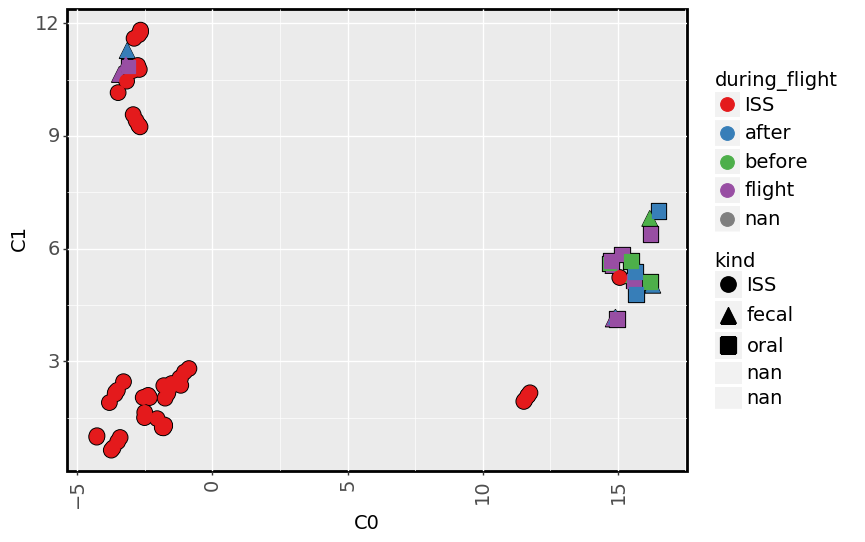

<ggplot: (8733726303566)>

In [48]:
(
    ggplot(u, aes(x='C0', y='C1', color='during_flight', shape='kind')) +
        geom_point(size=5.8, color='black') +
        geom_point(size=5) +
        scale_color_brewer(type='qualitative', palette=6, direction=1) +
        theme(
            text=element_text(size=14),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(8, 6),
        )
)

In [74]:
comps = tbl.copy().fillna(0)
comps['flight'] = comps.index.map(lambda x: getit('flight', x))
comps = comps.groupby('flight').sum().T
comps

flight,ISS,after,before,flight,ground
0,49.0,6.0,5.0,10.0,23.0
1,45.0,4.0,5.0,8.0,12.0
2,47.0,6.0,5.0,10.0,23.0
3,48.0,6.0,5.0,10.0,23.0
4,43.0,5.0,5.0,7.0,19.0
...,...,...,...,...,...
32646,1.0,0.0,0.0,0.0,0.0
32647,1.0,0.0,0.0,0.0,0.0
32648,1.0,0.0,0.0,0.0,0.0
32649,1.0,0.0,0.0,0.0,0.0


In [83]:
env_comps = set(comps.query('ISS > 0').index.to_list())

In [69]:
new_bcs = comps.query('before == 0').query('flight > 1')
new_env_bcs = new_bcs.query('ISS > 1')
new_nonenv_bcs = new_bcs.query('ISS == 0')

print(new_env_bcs.shape)
print(new_nonenv_bcs.shape)

(42, 5)
(2607, 5)


In [70]:
new_env_bcs

flight,ISS,after,before,flight,ground
9100,4.0,3.0,0.0,2.0,12.0
12590,2.0,3.0,0.0,2.0,7.0
12740,42.0,3.0,0.0,3.0,6.0
12878,4.0,3.0,0.0,3.0,9.0
12973,2.0,1.0,0.0,3.0,6.0
13430,2.0,2.0,0.0,2.0,5.0
13891,2.0,3.0,0.0,2.0,10.0
13892,40.0,5.0,0.0,2.0,11.0
14593,3.0,3.0,0.0,2.0,7.0
14700,3.0,3.0,0.0,2.0,12.0


In [76]:
new_nonenv_bcs

flight,ISS,after,before,flight,ground
214,0.0,1.0,0.0,2.0,1.0
423,0.0,1.0,0.0,2.0,1.0
549,0.0,1.0,0.0,2.0,1.0
682,0.0,1.0,0.0,2.0,5.0
754,0.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...
29595,0.0,0.0,0.0,2.0,0.0
29599,0.0,0.0,0.0,2.0,0.0
29617,0.0,0.0,0.0,2.0,0.0
29618,0.0,0.0,0.0,2.0,0.0


In [89]:
foo = tbl.copy()
foo['sample_name'] = foo.index
foo = foo.melt(id_vars='sample_name')
foo = foo.dropna()
foo['environmental'] = foo['variable'].map(lambda x: 'env' if x in env_comps else 'nonenv')
foo = foo.groupby(('sample_name', 'environmental')).sum()
foo = foo.reset_index()

foo['date'] = foo['sample_name'].map(lambda x: getit('date', x))
#foo['date'] = pd.to_datetime(foo['date'])
foo['kind'] = foo['sample_name'].map(lambda x: getit('kind', x))
foo['during_flight'] = foo['sample_name'].map(lambda x: getit('during_flight', x))

foo['subject'] = foo['sample_name'].map(lambda x: getit('subject', x))
foo = foo.dropna()
foo = foo.query('subject == "TW"')


foo

,sample_name,environmental,value,date,kind,during_flight,subject
0,011515_TW_B,env,1080.0,2015-01-15,buccal,before,TW
1,011515_TW_B,nonenv,924.0,2015-01-15,buccal,before,TW
2,011515_TW_S,env,2334.0,2015-01-15,saliva,before,TW
3,011515_TW_S,nonenv,5795.0,2015-01-15,saliva,before,TW
12,012715_TW_B,env,2310.0,2015-01-27,buccal,before,TW
13,012715_TW_B,nonenv,2958.0,2015-01-27,buccal,before,TW
14,030116_TW_B,env,1044.0,2016-03-01,buccal,flight,TW
15,030116_TW_B,nonenv,704.0,2016-03-01,buccal,flight,TW
16,030116_TW_S,env,2127.0,2016-03-01,saliva,flight,TW
17,030116_TW_S,nonenv,2765.0,2016-03-01,saliva,flight,TW


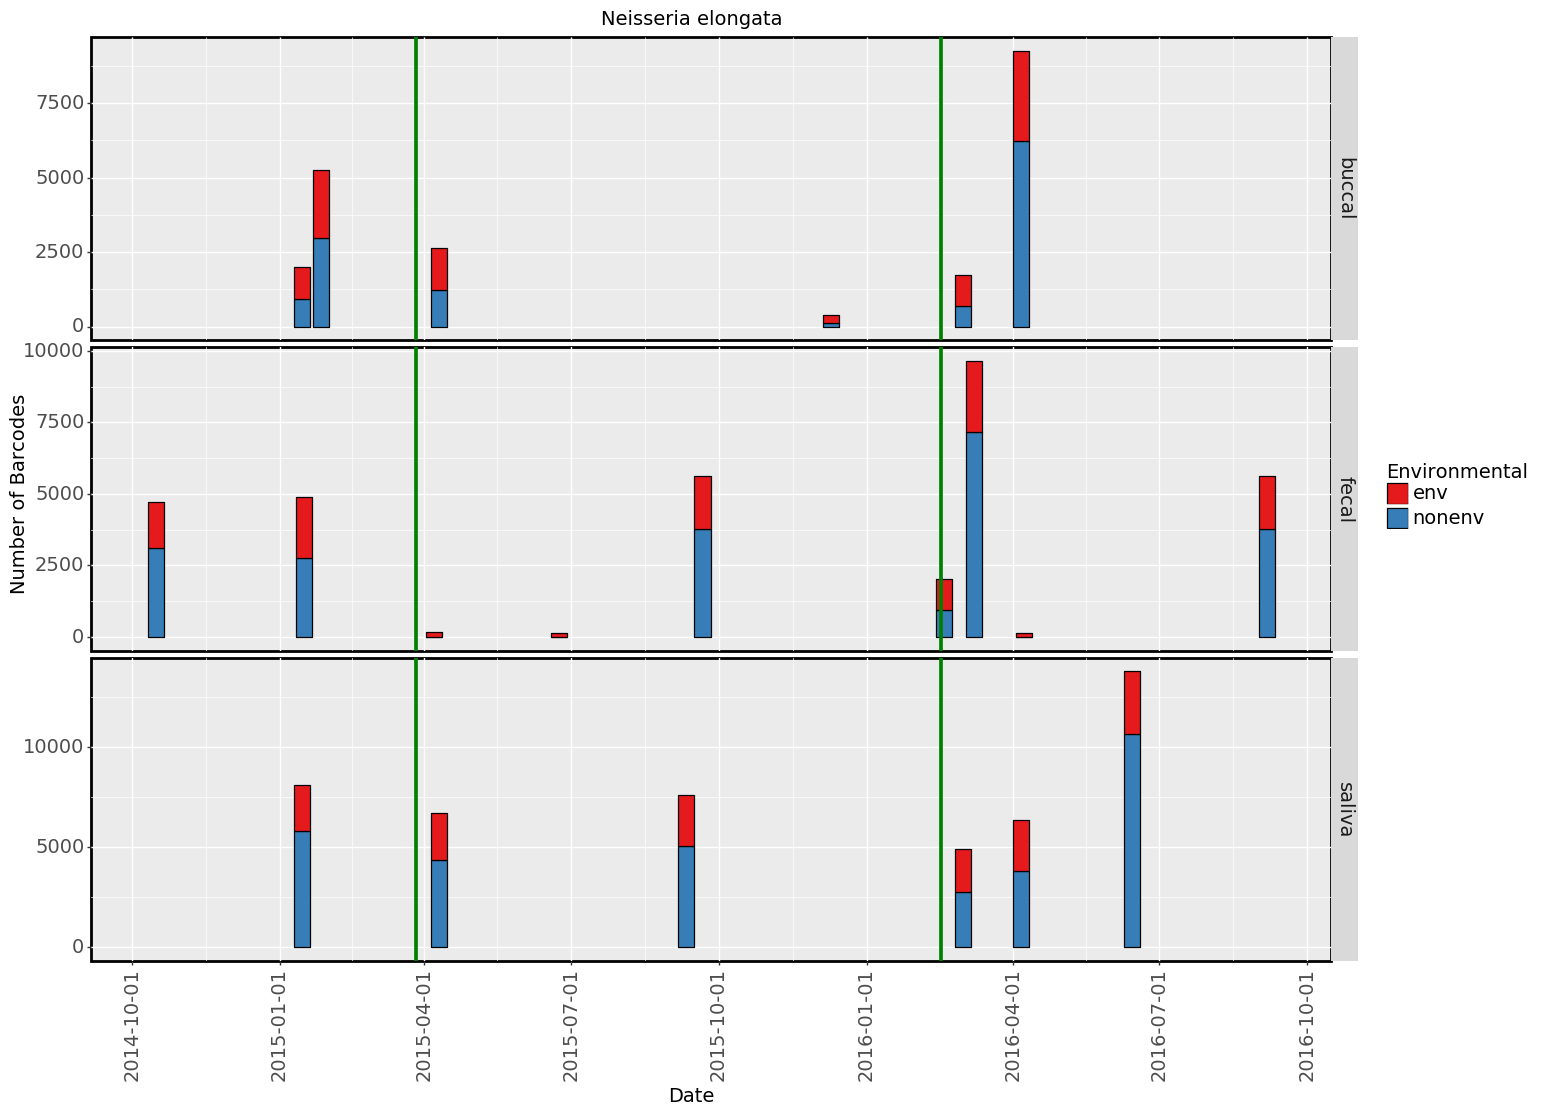

<ggplot: (-9223363303127420507)>

In [92]:
(
    ggplot(foo, aes(x='date', y='value', fill='environmental')) +
        geom_col(width=10, color='black') +
        facet_grid('kind~', scales='free') +
        scale_x_date() +
        scale_fill_brewer(type='qualitative', palette=6, direction=1) +
        xlab(f'Date') +
        ylab(f'Number of Barcodes') +
        labs(fill='Environmental') +
        ggtitle('Neisseria elongata') +
        geom_vline(xintercept='2015-03-27', color='green', size=1.5) +
        geom_vline(xintercept='2016-02-16', color='green', size=1.5) +
        theme(
            text=element_text(size=14),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 12),
        )
)

In [129]:

def barcode_set(samples):
    s = tbl.loc[samples].sum()
    s = set(s[s > 0].index)
    return s

mymeta = meta.copy()
mymeta['sample_name'] = mymeta.index

def source_barcodes(kind, permute=False):
    meta = mymeta.loc[set(tbl.index) & set(mymeta.index)]
    target_samples = meta.query('subject == "TW"').query('kind == @kind').query('flight == "flight"').index.to_list()
    sources = meta.query('subject == "TW"').query('flight == "before"')
    if permute:
        target_samples = meta.query('subject == "TW"').query('kind == @kind').sample(len(target_samples)).index.to_list()
        sources = meta.query('subject == "TW"').query('sample_name not in @target_samples').sample(len(sources))
    saliva_sources = sources.query('kind == "saliva"').index.to_list()
    fecal_sources = sources.query('kind == "fecal"').index.to_list()
    iss_sources = iss_meta.index.to_list()
    source_order = [('fecal', fecal_sources), ('saliva', saliva_sources), ('ISS', iss_sources)]
    if kind == 'saliva':
        source_order = [('saliva', saliva_sources), ('fecal', fecal_sources), ('ISS', iss_sources)]
    bc_source_sets = [(n, barcode_set(source)) for n, source in source_order]
    target_bc_set = barcode_set(target_samples)
    out = {}
    for name, bc_set in bc_source_sets:
        out[name] = len(bc_set & target_bc_set)
        target_bc_set -= bc_set
    out['remainder'] = len(target_bc_set)
    return out
    
source_barcodes('fecal', False)

{'fecal': 2863, 'saliva': 508, 'ISS': 227, 'remainder': 3016}

In [138]:
flow_tbl = {}
flow_tbl[0] = source_barcodes('fecal', False)
for i in range(1000):
    flow_tbl[i + 1] = source_barcodes('fecal', True)
flow_tbl = pd.DataFrame.from_dict(flow_tbl, orient='index')

flow_tbl

,fecal,saliva,ISS,remainder
0,2863,508,227,3016
1,147,8824,54,436
2,129,2929,496,2153
3,134,6914,118,2298
4,3371,3281,136,2676
...,...,...,...,...
9996,5622,1883,289,3324
9997,3117,3166,100,2350
9998,129,9273,118,2098
9999,2930,6587,156,4764


In [139]:
flow_proportions = 100 * (flow_tbl.T / flow_tbl.sum(axis=1)).T
flow_proportions.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,fecal,saliva,ISS,remainder
0.0,0.000000,0.000000,0.000000,0.000000
0.1,0.000000,0.035549,0.368431,5.756893
0.2,1.160281,10.598679,0.939368,14.060964
0.3,10.697355,18.865298,1.305285,23.351202
0.4,20.315855,27.226495,1.697361,29.377827
0.5,25.088525,35.593997,2.082975,35.296469
0.6,31.255115,42.634551,2.533290,41.085572
0.7,36.824324,51.729819,3.128639,45.833333
0.8,43.273881,60.383918,4.004836,51.181802
0.9,54.812017,71.212642,5.791367,57.455885


In [140]:
(1000 - (flow_proportions.iloc[1:] >= flow_proportions.iloc[0]).sum()) / 100

fecal        80.07
saliva       15.20
ISS          74.18
remainder    69.57
dtype: float64

In [141]:
flow_proportions.head(1)

,fecal,saliva,ISS,remainder
0,43.286967,7.680677,3.432114,45.600242


In [143]:

flow_tbl = {}
flow_tbl[0] = source_barcodes('saliva', False)
for i in range(1000):
    flow_tbl[i + 1] = source_barcodes('saliva', True)
flow_tbl = pd.DataFrame.from_dict(flow_tbl, orient='index')

flow_proportions = 100 * (flow_tbl.T / flow_tbl.sum(axis=1)).T
flow_proportions.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

(1000 - (flow_proportions.iloc[1:] >= flow_proportions.iloc[0]).sum()) / 10

saliva       58.8
fecal        75.7
ISS          30.7
remainder    14.2
dtype: float64